In [1]:
import zipfile

# Extracting ZIP file for the images and CSV file
with zipfile.ZipFile('/content/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

#Imports

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

#Exploratory Data Analysis

In [3]:
data_main = pd.read_csv('/content/data_labels_mainData.csv')
data_main = data_main[['ImageName', 'cellType']]
data_main.head()

,ImageName,cellType
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


In [4]:
data_main['cellType'].value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

In [5]:
data_main['cellType'] = data_main['cellType'].astype('str')

Splitting the Data

In [6]:
#Splitting data into train, test and validation
train_data, test_data = train_test_split(data_main, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


# Baseline Model

In [7]:
# Converting the data labels to string
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Real time data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_2 = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator_2 = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# test data generator for evaluating the performance of a previously trained model on a test dataset
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator_2 = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [9]:
#Setting dimensions and classes for the model
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

import tensorflow as tf

#Creating new model and adding layers
basemodel = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

basemodel.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2187)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               560128    
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


In [10]:
basemodel.compile(optimizer='SGD',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [11]:
history_3 = basemodel.fit(train_generator_2, validation_data = valid_generator_2, epochs=10)

Epoch 1/10
186/186 [==============================] - 8s 16ms/step - loss: 1.2966 - accuracy: 0.4413 - val_loss: 1.1932 - val_accuracy: 0.4199
Epoch 2/10
186/186 [==============================] - 4s 20ms/step - loss: 1.0795 - accuracy: 0.5582 - val_loss: 0.9346 - val_accuracy: 0.6281
Epoch 3/10
186/186 [==============================] - 3s 15ms/step - loss: 1.0099 - accuracy: 0.5883 - val_loss: 0.9209 - val_accuracy: 0.6013
Epoch 4/10
186/186 [==============================] - 3s 15ms/step - loss: 0.9464 - accuracy: 0.6195 - val_loss: 0.8607 - val_accuracy: 0.6337
Epoch 5/10
186/186 [==============================] - 4s 21ms/step - loss: 0.9127 - accuracy: 0.6321 - val_loss: 0.8923 - val_accuracy: 0.6230
Epoch 6/10
186/186 [==============================] - 3s 16ms/step - loss: 0.8925 - accuracy: 0.6439 - val_loss: 0.9076 - val_accuracy: 0.6256
Epoch 7/10
186/186 [==============================] - 3s 15ms/step - loss: 0.8530 - accuracy: 0.6641 - val_loss: 0.8449 - val_accuracy: 0.6625

# Evaluation, Learning Curve and Metrics

In [12]:
basemodel.evaluate(train_generator_2)
basemodel.evaluate(test_generator_2)
basemodel.evaluate(valid_generator_2)

62/62 [==============================] - 1s 16ms/step - loss: 0.7703 - accuracy: 0.7004


[0.7703452110290527, 0.700353741645813]

In [13]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(6,3))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

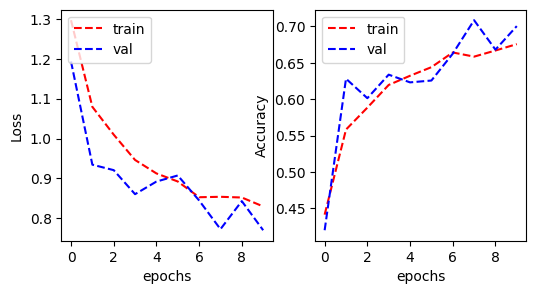

In [14]:
plot_learning_curve(history_3.history['loss'],history_3.history['val_loss'], 
                    history_3.history['accuracy'], history_3.history['val_accuracy'], 
                    metric_name='Accuracy')

In [15]:
from sklearn.metrics import classification_report
import numpy as np

# Assuming valid_generator is your data generator
y_true = test_generator_2.classes  # True class labels
y_pred_prob = basemodel.predict(test_generator_2)  # Predicted probabilities for each class

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute the classification report
report = classification_report(y_true, y_pred)
print(report)


62/62 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.20      0.15      0.17       372
           1       0.24      0.34      0.28       504
           2       0.43      0.50      0.46       803
           3       0.11      0.02      0.03       301

    accuracy                           0.32      1980
   macro avg       0.24      0.25      0.24      1980
weighted avg       0.29      0.32      0.30      1980



#**Performing data augmentation on train data to balance the binary classes**

In [16]:
data = pd.read_csv('/content/data_labels_mainData.csv')
data = data[['ImageName', 'cellType']]


In [17]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42,stratify= data['cellType'])

In [18]:
test_data

,ImageName,cellType
856,9162.png,1
9122,12135.png,2
359,181.png,1
8299,3653.png,2
2645,18326.png,0
...,...,...
7491,674.png,0
5832,19889.png,1
9131,12147.png,2
108,18872.png,1


In [19]:
test_data['cellType'].value_counts()

2    408
1    254
0    189
3    139
Name: cellType, dtype: int64

In [20]:
train_data['cellType'].value_counts()

2    3671
1    2289
0    1699
3    1247
Name: cellType, dtype: int64

In [21]:
train_df = train_data

In [22]:
train_df.head()

,ImageName,cellType
1702,13444.png,1
4611,16714.png,3
5790,19846.png,1
6982,1294.png,3
5423,11785.png,2


In [23]:
import pandas as pd

# Assuming you have a DataFrame called 'df' with columns 'ImageName' and 'Class'

# Group the DataFrame by 'Class'
grouped_df = train_data.groupby('cellType')

# Create empty dictionaries to store the separated DataFrames
class_dfs = {}

# Iterate over the groups and create separate DataFrames for each class
for class_label, group in grouped_df:
    class_dfs[class_label] = group.drop('cellType', axis=1).copy()

# Access the separated DataFrames using the class label as the key
class0_df = class_dfs[0]
class1_df = class_dfs[1]
class2_df = class_dfs[2]
class3_df = class_dfs[3]

##Data augmentation

In [24]:
# all the augmented images are stored in different floder so moving those folders into one folder 

import shutil

def move_augmented_files(source_dir, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)

    for file_name in os.listdir(source_dir):
        if file_name.startswith("augmented"):
            source_path = os.path.join(source_dir, file_name)
            destination_path = os.path.join(destination_dir, file_name)
            shutil.move(source_path, destination_path)

In [25]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator

def augment_data(df, output_dir, num_augmentations=1):
    datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

    augmented_image_paths = []

    for _, row in df.iterrows():
        image_name = row['ImageName']
        image_path = os.path.join(image_base_folder, image_name)

        # Load the image
        img = Image.open(image_path)
        img = img.resize((27, 27))

        # Get the file name without extension
        file_name = os.path.splitext(image_name)[0]

        # Perform data augmentation
        img_arr = np.array(img)
        img_arr = np.expand_dims(img_arr, axis=0)  # Add batch dimension for data generator

        datagen.fit(img_arr)

        augmented_image_name = f"augmented_{os.path.splitext(os.path.basename(image_path))[0]}.png"
        augmented_image_path = os.path.join(output_dir, augmented_image_name)

        for i, batch in enumerate(datagen.flow(img_arr, batch_size=1, save_to_dir=output_dir, save_prefix='', save_format='png')):
            augmented_image_temp_path = os.path.join(output_dir, f"temp_augmented_{i}.png")
            Image.fromarray(batch[0].astype(np.uint8)).save(augmented_image_temp_path)
            os.rename(augmented_image_temp_path, augmented_image_path)
            augmented_image_paths.append(augmented_image_path)
            break  # Generate only one augmented image per original image

            if i >= num_augmentations - 1:
                break  # Stop after generating the specified number of augmented images

    return augmented_image_paths

# Define your DataFrame 'df' with the 'ImageName' column
 
# Determine the number of augmented images to create based on the multiplier


## class 0 

In [26]:
# Define the base path to the folder containing the images
image_base_folder = "/content/patch_images"

# Define the paths to the augmented dataset
augmented_dir = "/content/augmented_dataset10"
augmented_image_dir = os.path.join(augmented_dir)

# Create the augmented dataset directories if they don't exist
os.makedirs(augmented_image_dir, exist_ok=True)
# Data augmentation parameters


multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class0_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class0_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class0_df  = pd.concat([class0_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

In [27]:
multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class0_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class0_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class0_df  = pd.concat([class0_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

## Class 1

In [28]:
multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class1_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class1_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class1_1_df  = pd.concat([class1_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

In [29]:
class1_df  = pd.concat([class1_df, class1_1_df], ignore_index=True)

## Class 2

In [30]:
multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class2_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class2_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class2_df  = pd.concat([class2_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

## Class 3

In [31]:
multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class3_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class3_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class3_3_df  = pd.concat([class3_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

In [32]:
multiplier = 2  # Set the desired augmentation factor
num_augmentations = len(class3_3_df) * multiplier

# Perform data augmentation and get the augmented image names
augmented_image_paths = augment_data(class3_3_df, augmented_dir, num_augmentations)

# Update the 'ImageName' column with augmented image names
augmented_df = pd.DataFrame({'ImageName': [os.path.basename(image_path) for image_path in augmented_image_paths]})

# Concatenate the augmented DataFrame with the original majority class DataFrame

# Update the original DataFrame with the augmented image names and class labels
class3_3_3_df  = pd.concat([class3_3_df, augmented_df], ignore_index=True)

move_augmented_files(augmented_dir, image_base_folder)

In [33]:
class3_df  = pd.concat([class3_3_3_df, class3_df], ignore_index=True)

In [34]:
class0_df['cellType'] = '0'
class1_df['cellType'] = '1'
class2_df['cellType'] = '2'
class3_df['cellType'] = '3'

merged_df = pd.concat([class0_df, class1_df, class2_df, class3_df], ignore_index=True)


In [37]:
merged_df['cellType'].value_counts()

2    7342
1    6867
0    6796
3    6235
Name: cellType, dtype: int64

In [35]:
train_data, val_data = train_test_split(merged_df, test_size=0.10, random_state=0)
# Converting the data labels to string

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Real time data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator_2 = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator_2 = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# test data generator for evaluating the performance of a previously trained model on a test dataset
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator_2 = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 24516 validated image filenames belonging to 4 classes.
Found 2724 validated image filenames belonging to 4 classes.
Found 990 validated image filenames belonging to 4 classes.


In [36]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 15.7 MB/s eta 0:00:00


#Keras tuner Model

In [38]:
import keras_tuner
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

# Define the model-building function
def build_model(hp):
    model = keras.Sequential()
    
    # Tune the number of layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=10, step=1)
    
    # Add convolutional layers
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=128, step=16),
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
        input_shape=(27, 27, 3)
    ))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(num_layers-1):
        model.add(keras.layers.Conv2D(
            filters=hp.Int('conv_{}_filter'.format(i+2), min_value=16, max_value=128, step=16),
            kernel_size=(3, 3),
            padding='same',
            activation='relu'
        ))
        
        # Add conditional check for pooling
        if model.output_shape[1] >= 2 and model.output_shape[2] >= 2:
            model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(keras.layers.Flatten())
    
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=4, step=1)
    
    # Add dense layers
    for i in range(num_dense_layers):
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=2, max_value=64, step=8),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=0.2))
    
    model.add(keras.layers.Dense(4, activation='softmax'))
    
    learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    
    # Compile the model
    model.build(input_shape=(None, 27, 27, 3))  # Build the model to initialize the weights
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.set_weights([tf.random.normal(layer.kernel.shape, mean=0, stddev=0.1), tf.zeros(layer.bias.shape[-1])])


    # Optimization Algorithm
    optimizer = SGD(lr=learning_rate, momentum=0.9)

    # Learning Rate Annealing


    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [40]:
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner
from tensorflow import keras

# Instantiate the tuner
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=15,
    directory='op0005dfdf778787856500000000',
    project_name='cancer_cell_detection'
)

earlyStopping_1 = EarlyStopping(
    monitor='val_loss',
    min_delta=0.05,
    patience=3,
    verbose=1,
    mode='auto'
)

# Perform the hyperparameter search
tuner.search(
    train_generator_2,
    epochs=51,
    validation_data=valid_generator_2,
    callbacks=[earlyStopping_1]
)

# Retrieve the best model
tue_model = tuner.get_best_models(1)[0]
tue_model.summary()

Trial 15 Complete [00h 00m 45s]
val_loss: 1.3840007781982422

Best val_loss So Far: 0.7027128338813782
Total elapsed time: 00h 17m 54s


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [47]:
tue_model.save("best_model.h5")

## Evaluation

In [46]:
from keras.models import load_model
tue_model.evaluate(test_generator_2)
tue_model.evaluate(train_generator_2)
tue_model.evaluate(valid_generator_2)

86/86 [==============================] - 1s 12ms/step - loss: 0.7027 - accuracy: 0.7081


[0.7027127742767334, 0.708149790763855]

In [45]:
from sklearn.metrics import classification_report
import numpy as np
from keras.utils import to_categorical

# Make predictions using the model on the generator data
# Make predictions using the model on the generator data
# Make predictions using the model on the generator data
y_pred_prob = tue_model.predict(test_generator_2)
y_pred = np.argmax(y_pred_prob, axis=1)

# Concatenate true labels from the generator data
y_true = np.concatenate([test_generator_2[i][1] for i in range(len(test_generator_2))])
y_true = np.argmax(y_true, axis=1)

# Print the true class labels, predicted probabilities, and predicted class labels side by side
# Convert true labels to multilabel-indicator format if necessary

# Compute the classification report
report = classification_report(y_true, y_pred)
print(report)


31/31 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.17      0.13      0.15       189
           1       0.26      0.33      0.29       254
           2       0.43      0.42      0.43       408
           3       0.12      0.11      0.11       139

    accuracy                           0.30       990
   macro avg       0.25      0.25      0.25       990
weighted avg       0.30      0.30      0.30       990

